### Procesamiento Lenguaje Natural la clasificación de textos e identificación los distintos temas dentro de un discurso.

Equipo BlackPink

La  información escrita es un medio de comunicación muy importante que a lo largo del tiempo se ha ido digitalizando, requiriendo ser compactado para la optimización del entendimiento de los seres humanos para con el mismo.
Así mismo identificación de temas en cualquier tipo de expresión oral o escrita nos permite formarnos una idea general de la información que podemos encontrar en el mismo, de igual forma se pueden asociar ideas generales a cada uno de estos temas. Así las aplicaciones de procesar un discurso y realizar clasificarlas pueden ser vastas, ya que esta clase de datos se encuentran desde artículos escritos, libros, canciones, podcast, conversaciones telefónicas y más, esto ayudaría a generar nueva información o contenido que sirva como una representación más concisa de ella.

In [ ]:
# Importamos todas las librerias que vamos a utilizar
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import string
import nltk
nltk.download('stopwords')
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Cargamos las bases
news_1 = pd.read_csv('inshort_news_data-1.csv')
news_2 = pd.read_csv('inshort_news_data-2.csv')
news_3 = pd.read_csv('inshort_news_data-3.csv')
news_4 = pd.read_csv('inshort_news_data-4.csv')
news_5 = pd.read_csv('inshort_news_data-5.csv')
news_6 = pd.read_csv('inshort_news_data-6.csv')
news_7 = pd.read_csv('inshort_news_data-7.csv')
news_data = [news_1,news_2,news_3,news_4,news_5,news_6,news_7]
news = pd.concat(news_data, ignore_index=True)

#### Procesamiento de texto

Para poder analizar textos con un modelo de aprendizaje de maquina primero es necesario procesarlo, para ello tenemos que eliminar caracteres especiales, eliminar espacios en blanco, signos de puntuación, urls y convertir todas las letras correspondientes al texto a letras minusculas.

In [ ]:
def clean_text(data):
    # Convertir & a &
    data = data.replace('&', '&')
    # Eliminar caracteres especiales y signos de puntuación
    data = re.sub(r'[^\w\s]', '', data)
    # Eliminar números
    data = re.sub(r'\d', ' ', data)
    # Convertir a minúsculas
    data = data.lower()
    # Eliminar espacios adicionales
    data = re.sub(r'\s+', ' ', data.strip())
    return data

def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

def preprocess_text(data):
    data = clean_text(data)
    data = remove_punctuations(data)
    data = remove_url(data)
    return data

#### Segmentación de texto

Segmentamos el texto con el que queremos alimentar a nuestro modelo por medio de la tokenización, es decir, necesitamos dividir un texto en pequeños fragmentos del mismo, con el fin de ingresarlos a cualquiera de nuestros algoritmos.

In [ ]:
def segment_text(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

nlp = spacy.load('en_core_web_sm')

#### Modelo para clasificación de texto y entrenamiento

Con este modelo nuestro objetivo es clasificar noticias con respecto al tema al que está haciendo referncia, para ello, utilizaremos un algoritmo de aprendizaje supervisado, es decir, una red neuronal con la biblioteca keras.

In [ ]:
# Preprocesar texto
news['text'] = news['news_headline'] + " " + news['news_article']
news['clean_text'] = news['text'].apply(preprocess_text)

# Tokenizacion
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(news['clean_text'])

# Convierte los tokens a numeros
sequences = tokenizer.texts_to_sequences(news['clean_text'])

# Padding sirve para que todas las secuencias tengan la misma longitud
max_length = 100  # Revisar cual es la noticia con mas palabras para ajustar
X = pad_sequences(sequences, maxlen=max_length)

# Convierte las categorias a numeros
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(news['news_category'])
y = to_categorical(y)

In [ ]:
# Parametros
vocab_size = 10000  # tamano del vocabulario
embedding_dim = 100  # dimension de los embeddings

# Input Layer define la entrada
input_layer = Input(shape=(max_length,), dtype='int32')

# Embedding Layer genera los embeddings
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_layer)

# LSTM Layer mantiene y descarta informacion
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

# Attention Layer, attention asigna pesos a las palabras no todas las palabras tienen el mismo significado en diferentes contextos
attention = Attention()([lstm_layer, lstm_layer])
attention = GlobalAveragePooling1D()(attention)

# Dense Layer y Output Layer
dense_layer = Dense(64, activation='relu')(attention)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Dividir los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
303/303 [==============================] - 75s 239ms/step - loss: 1.0628 - accuracy: 0.5820 - val_loss: 0.4680 - val_accuracy: 0.8560
Epoch 2/10
303/303 [==============================] - 66s 217ms/step - loss: 0.3096 - accuracy: 0.9078 - val_loss: 0.3207 - val_accuracy: 0.9072
Epoch 3/10
303/303 [==============================] - 70s 230ms/step - loss: 0.1765 - accuracy: 0.9499 - val_loss: 0.2393 - val_accuracy: 0.9323
Epoch 4/10
303/303 [==============================] - 71s 234ms/step - loss: 0.1340 - accuracy: 0.9562 - val_loss: 0.2187 - val_accuracy: 0.9373
Epoch 5/10
303/303 [==============================] - 62s 204ms/step - loss: 0.1241 - accuracy: 0.9584 - val_loss: 0.2101 - val_accuracy: 0.9352
Epoch 6/10
303/303 [==============================] - 72s 237ms/step - loss: 0.1054 - accuracy: 0.9612 - val_loss: 0.2087 - val_accuracy: 0.9365
Epoch 7/10
303/303 [==============================] - 63s 207ms/step - loss: 0.0951 - accuracy: 0.9628 - val_loss: 0.2321 - val_ac

#### Evaluación del modelo y ejemplo de clasificación

Precision y pérdida durante el entrenamiento y validacion:


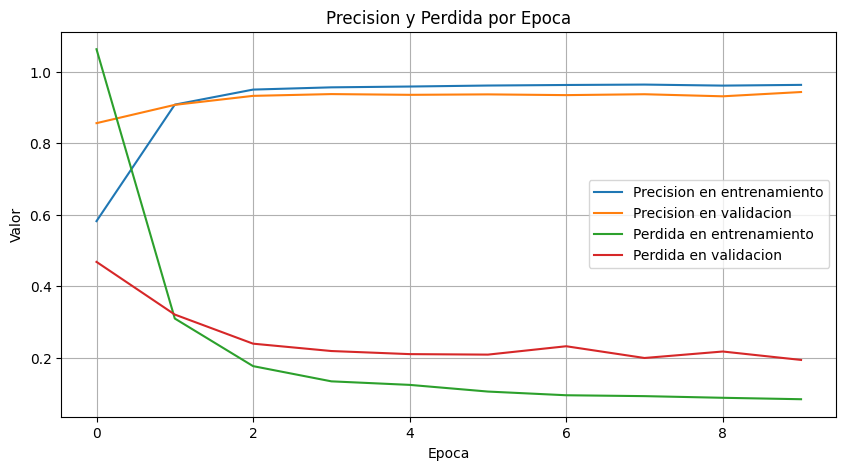

303/303 [==============================] - 20s 65ms/step - loss: 0.0683 - accuracy: 0.9685
Precision final en entrenamiento: 96.85%
Precision final en validacion: 94.31%
Precision final en entrenamiento: 6.83%
Perdida final en validacion: 19.38%
1/1 [==============================] - 0s 54ms/step
Prediccion de categoria: technology


In [ ]:
# Evaluar el modelo
# Difinicion de otras metricas de evaluacion
print("Precision y pérdida durante el entrenamiento y validacion:")
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label='Precision en entrenamiento')
plt.plot(epochs, history.history['val_accuracy'], label='Precision en validacion')
plt.plot(epochs, history.history['loss'], label='Perdida en entrenamiento')
plt.plot(epochs, history.history['val_loss'], label='Perdida en validacion')
plt.title('Precision y Perdida por Epoca')
plt.xlabel('Epoca')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir la precision final en la validacion
loss, accuracy = model.evaluate(X_val, y_val)
train_loss, train_accuracy = model.evaluate(X_train, y_train)

print(f'Precision final en entrenamiento: {train_accuracy*100:.2f}%')
print(f'Precision final en validacion: {accuracy*100:.2f}%')
print(f'Precision final en entrenamiento: {train_loss*100:.2f}%')
print(f'Perdida final en validacion: {loss*100:.2f}%')



# Clasificar una nueva noticia tomando solo el texto
def classify_news(text):
    clean_text = preprocess_text(text)
    tokens = word_tokenize(clean_text)
    sequence = tokenizer.texts_to_sequences([tokens])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_class)[0]

# Ejemplo con una nueva noticia, de categoria technology
new_news = "Satellite pics show remains of SpaceX's rocket prototype after explosion,Satellite images showed the remains of Elon Musk-led SpaceX's Starship rocket prototype that crash-landed and exploded on Wednesday during a test launch. The 16-storey prototype of the Starship spaceship travelled more than five minutes upward in the air before crash landing at the SpaceX's launch site in Texas. Satellite images showed Starship nosecone lying beside the remains of the spaceship."
predicted_category = classify_news(new_news)
print(f'Prediccion de categoria: {predicted_category}')

In [ ]:
def test_information(text, news_category, user_category, prediction):
    return '\n    Categoria correcta:' + news_category + '\n    Categoria de usuario:' + user_category + '\n    Prediccion: ' + prediction + '\n    Noticia: ' + text

# Funcion que imprime si se eligio una noticia correcta para el usuario
def user_choice(text, news_category, user_category, prediction):
    if prediction == user_category:
        if prediction == news_category:
            print('Se eligio una noticia correcta para el usuario' + test_information(text, news_category, user_category, prediction))
        else:
            print('Se eligio una noticia incorrecta para el usuario: ' + test_information(text, news_category, user_category, prediction))
        return text
    elif news_category == user_category:
        print('No se eligio una noticia correcta para el usuario: ' + test_information(text, news_category, user_category, prediction))
    else:
        print('No se eligio una noticia incorrecta para el usuario: ' + test_information(text, news_category, user_category, prediction))
    return ""

# Toma un conjunto de noticias y noticias de otro data set, dependiendo de la categoria favorita del usuario regresa las noticias con esa categoria
def user_news(num_news, user_category):
    chosen_news = []
    errors = []
    new_news = {"politics" : "\u2018Beautiful And Sad At The Same Time\u2019: Ukrainian Cultural Festival Takes On A Deeper Meaning This Year. An annual celebration took on a different feel as Russia's invasion dragged into Day 206.",
                "science" : "No Life On Martian Meteorite Found In Antarctica In 1996. Orginally, scientists thought organic compounds in the rock may have been left by living creatures, but the marks were actually caused by salty water.",
                "sports" : "The Legendary Cristiano Ronaldo Scores A Legendary 'Bicycle Kick' Goal. So utterly ridiculous.",
                "technology" : "Joshua Pearce, ContributorDirector, Michigan Tech Open Sustainability Technology Lab. A relatively minor investment in retraining would allow the majority of coal workers to switch to solar-related positions.",
                "world" : "Jim Yong Kim Starts His Second Term As World Bank President Despite A Rocky First 5 Years. Kim\u2019s leadership has endured consistent criticism.",
                "automobile" : "From Walls to Wheels: Driving Art in High Gear. Sir Alfred DiMora showed a special enthusiasm for cars at ten years old when he began to race miniature slot cars, which led to a genuine passion for the automobile. By the time he was thirteen, he dreamed of building his own car, and, like most genuine passions, simply would not let go until the goal was realized.",
                "entertainment" : "Taylor Swift Throws Baby Shower, Invites A Thousand Of Her Closest Friends"}
    index = random.sample(range(0, 12120), num_news)
    for i in index:
        text_news = news['text'][i]
        prediction = classify_news(text_news)
        choice = user_choice(text_news, news['news_category'][i], user_category, prediction)
        chosen_news.append(choice)
    for category in new_news:
        new_text = new_news[category]
        prediction = classify_news(new_text)
        choice = user_choice(new_text, category, user_category, prediction)
        chosen_news.append(choice)

user_news(7, 'science')

1/1 [==============================] - 0s 38ms/step
No se eligio una noticia incorrecta para el usuario: 
    Categoria correcta:sports
    Categoria de usuario:science
    Prediccion: sports
    Noticia: India lose a T20I for the 1st time in a year as Aus end their 11-match unbeaten run Australia defeated India by 12 runs in the third T20I in Sydney on Tuesday as India clinched the three-match series 2-1. This is India's first defeat in a T20I match since December 8, 2019. India were on an 11-match unbeaten streak in T20I cricket. Team India captain Virat Kohli top-scored in the match with 85 runs off 61 balls.
1/1 [==============================] - 0s 34ms/step
No se eligio una noticia incorrecta para el usuario: 
    Categoria correcta:world
    Categoria de usuario:science
    Prediccion: world
    Noticia: We are vaccinating 2 lakh people a day against COVID-19: UK The UK is vaccinating over 2 lakh people a day against coronavirus, the country's Health Secretary Matt Hancock said 

### Extracción de subtemas

Extraemos los subtemas de los textos, con el fin de realizar una división de los mismos en secciones, de esta forma ayudamos a lector a tener una mejor comprensión del texto además de encontrar información relevante de una manera más rápida y consisa.

In [ ]:
def extract_keywords(sentences):
    all_keywords = []
    for sentence in sentences:
        doc = nlp(sentence)
        keywords = [token.text for token in doc if token.pos_ in ['NOUN', 'VERB']]
        all_keywords.extend(keywords)
    return all_keywords

def get_top_keywords(keywords, num=10):
    keyword_freq = Counter(keywords)
    return keyword_freq.most_common(num)

def cluster_keywords(keywords, num_clusters=5):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(keywords)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
    clusters = kmeans.labels_.tolist()

    keyword_clusters = {}
    for i, keyword in enumerate(keywords):
        cluster_id = clusters[i]
        if cluster_id not in keyword_clusters:
            keyword_clusters[cluster_id] = []
        keyword_clusters[cluster_id].append(keyword)
    return keyword_clusters

def extract_subtopics(text, num_clusters=5, num_keywords=10):
    # Preprocesamos nuestro texto
    processed_text = preprocess_text(text)
    sentences = segment_text(processed_text)

    # Extraer palabras clave
    keywords = extract_keywords(sentences)

    # Obtener las palabras clave más frecuentes
    top_keywords = get_top_keywords(keywords, num_keywords)
    top_keywords_list = [keyword for keyword, _ in top_keywords]

    # Agrupar palabras clave en subtemas
    subtopics = cluster_keywords(top_keywords_list, num_clusters)
    return subtopics

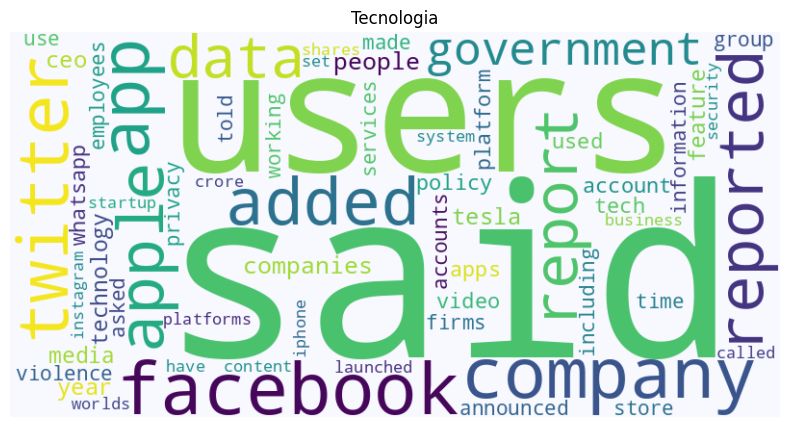

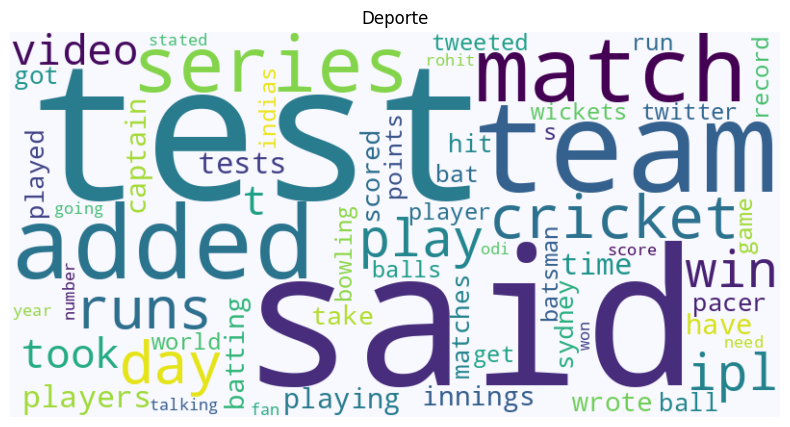

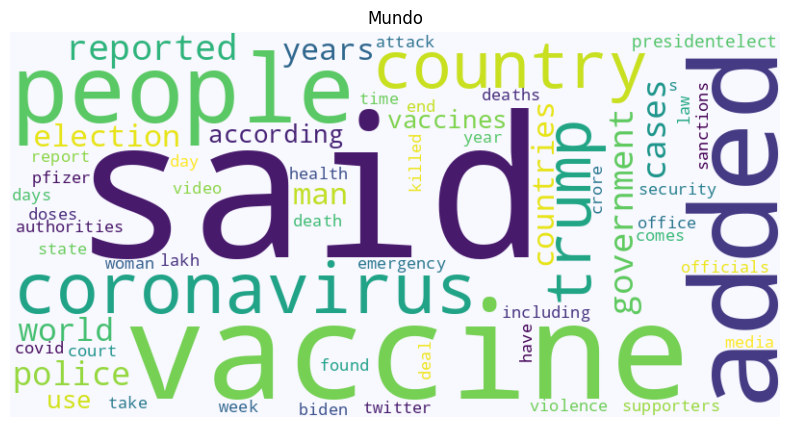

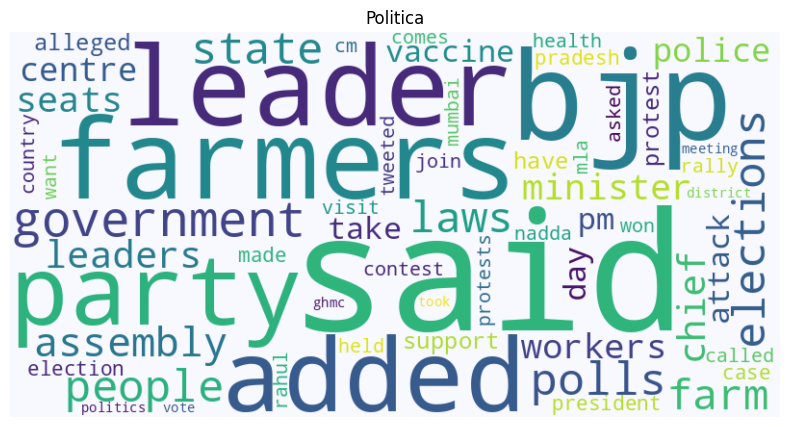

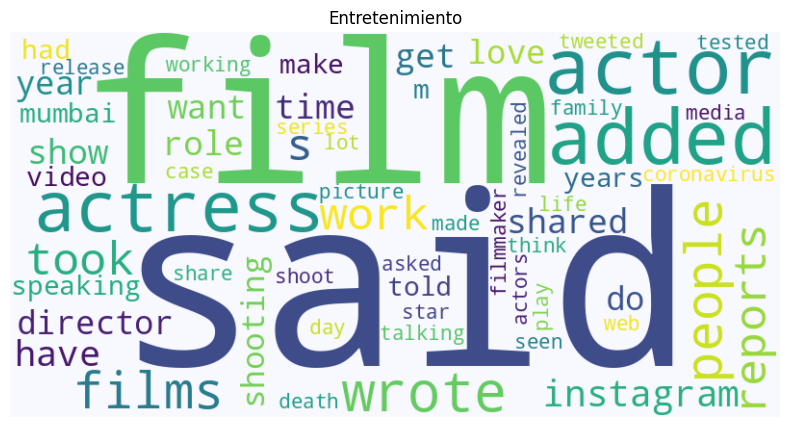

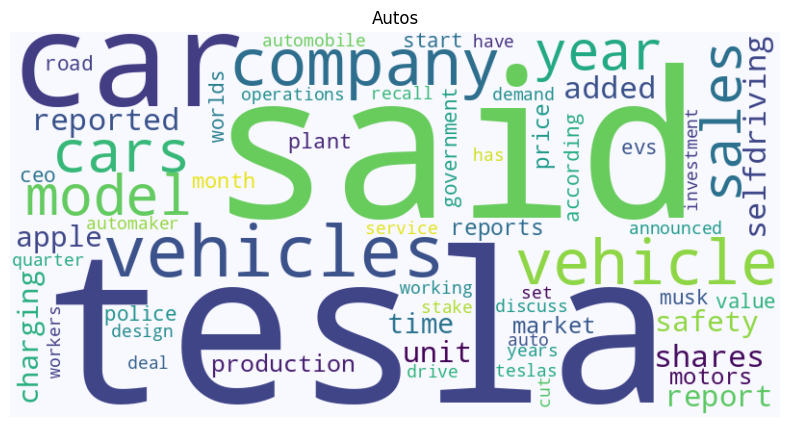

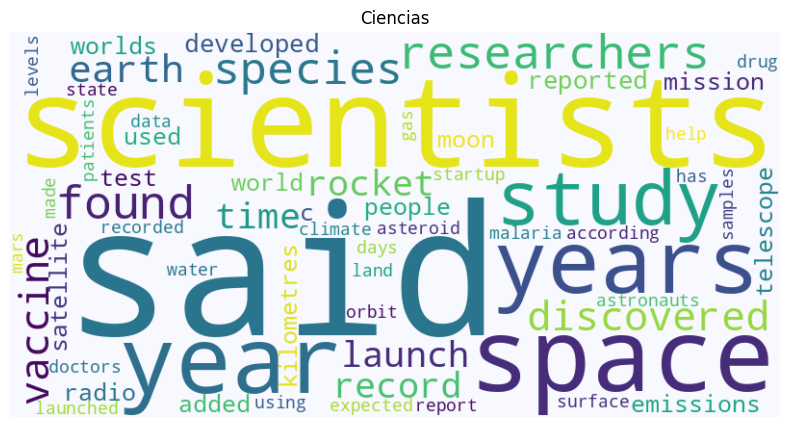

In [ ]:
from wordcloud import WordCloud

# Cree este nuevo DataFrame para no afectar al original D:
data_wordcloud = [news_1,news_2,news_3,news_4,news_5,news_6,news_7]
news_wordcloud = pd.concat(data_wordcloud, ignore_index=True)

# Se unen los titulos y el contenido para tener mas informacion
news_wordcloud['text'] = news_wordcloud['news_headline'] + " " + news_wordcloud['news_article']


# Genera la grafica wordcloud a partir de una lista de tuplas de frecuencias y la categoria
def generate_wordcloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='#F8F8FF').generate_from_frequencies(dict(frequencies))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preprocesa el texto que pertenece a la categoria y obtiene las frecuencias de las n palabras mas repetidas
def text_wordcloud(category, num):
    text_frequencies = ''.join(news_wordcloud[news_wordcloud['news_category'] == category]['text'])
    text_frequencies = clean_text(text_frequencies)
    text_frequencies = remove_punctuations(text_frequencies)
    text_frequencies = remove_url(text_frequencies)
    text_frequencies = segment_text(text_frequencies)
    text_frequencies = extract_keywords(text_frequencies)
    text_frequencies = get_top_keywords(text_frequencies, num)
    return text_frequencies

generate_wordcloud(text_wordcloud('technology', 60), 'Tecnologia')
generate_wordcloud(text_wordcloud('sports', 60), 'Deporte')
generate_wordcloud(text_wordcloud('world', 60), 'Mundo')
generate_wordcloud(text_wordcloud('politics', 60), 'Politica')
generate_wordcloud(text_wordcloud('entertainment', 60), 'Entretenimiento')
generate_wordcloud(text_wordcloud('automobile', 60), 'Autos')
generate_wordcloud(text_wordcloud('science', 60), 'Ciencias')
